In [ ]:
# default_exp dataprep

In [ ]:
#export
from fastai import *
from fastai.vision import *
from fastai.data_block import *
import nibabel as nib
from fastai.callbacks import *
from fastai.vision.data import SegmentationProcessor

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
path = Path('/media/ismael/01D2273CA76327A0/datasets/acdc_MICCAI17/acdc_train')

In [ ]:
nib.__version__

'2.2.1'

# dataprep

> Definitions of custom classes and methods for handling MRI images following the dataBlock API.
* `MRImage`: class for manipulating MRI images
* `MRImageSegment`: carries MRImage segmentation masks
* `MRImageList`: like ImageList for Image
* `MRImageSegLabelList`: equivalent of Image 

The idea behind these classes is to wrap all slices within a given MRI and perform all operations (e.g:

transformations, visualizations, etc...) on each slice
using the `Image` and `ImageSegment` classes.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
def _resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`."
    for f in listify(tfms): f.resolve()
        
def resize_slices(n, slices):
    slices = listify(slices)
    diff = len(slices) - n
    sl = []
    if diff>0:
        start = np.random.randint(0, diff)
        sl = [slices[i] for i in range(start, start+n)]
    else: 
        sl = slices + [slices[i] for i in range(-diff)]
    assert n == len(sl), f'n={n}, len(new_slice)={len(sl)}'
    return sl
    
        
def apply_trans(tfms, slices, slicewise, cls=(None, None), **kwargs):
    "Apply different transformations on each slice if `slicewise` is True and the same ones otherwise"
    if 'size' in kwargs:
        size = kwargs['size']
        assert len(size) >= 2
        slices = resize_slices(size[0], slices)
        kwargs['size'] = size[1:]
    if slicewise: # this case creates mismatch between slices and their labels!
        print(f'"slicewise = True" creates mismatch between slices and their labels!')
        x = cls[0]([cls[1](s).apply_tfms(tfms, **kwargs).data for s in slices])
    else:
        if len(tfms[0].resolved) == 0: _resolve_tfms(tfms)
        kwargs['do_resolve'] = False
        x = cls[0]([cls[1](s).apply_tfms(tfms, **kwargs).data for s in slices])
    return x
        
class MRImage(ItemBase):

    def __init__(self, imageList:Collection[Tensor]):
        self.slices = imageList if is_listy(imageList) else listify(imageList)
        self.px = torch.stack(self.slices)
        
    @property
    def data(self)->TensorImage: return self.px
        
    @property
    def shape(self)->Tuple[int,int,int,int]: return tuple([*self.data.shape])
    @property
    def size(self)->Tuple[int,int]: return (self.shape[0], self.shape[-2:])
    @property
    def device(self)->torch.device: return self.data.device
    
    def __repr__(self): return f'{self.__class__.__name__} {tuple(self.shape)}'
        
        
    def apply_tfms(self, tfms, slicewise=False, **kwargs):
        return apply_trans(tfms, self.slices, slicewise, (MRImage, Image), **kwargs)
    
    def to_one(self): 
        "Concatenate all slices into a single Image object"
        return Image(torch.cat([d for d in self.data], 2))
    
    def show(self, axs:plt.Axes=None, figsize:tuple=(40,40), title:Optional[str]=None, hide_axis:bool=True,
              cmap:str=None, y:Any=None, slice_idxs=np.arange(5), **kwargs):
        "Show image on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`"
        cmap = ifnone(cmap, defaults.cmap)
        assert min(slice_idxs) >=0 and max(slice_idxs) <= self.shape[0]
        slices = [self.slices[i] for i in slice_idxs]
        if axs is None: 
            cols = len(slices)
            fig,axs = plt.subplots(1, cols, figsize=figsize)
        
        assert len(axs) == len(slices)
        if y:
            yy = [y.slices[i] for i in slice_idxs]
            for x,y_,ax in zip(slices, yy, axs): 
                Image(x).show(ax=ax, y=ImageSegment(y_), **kwargs)
        else:
            for x,ax in zip(slices, axs): 
                Image(x).show(ax=ax, **kwargs)

In [ ]:
#export
class MRImageSegment(MRImage):
    "Support applying transforms to segmentation masks data in `px`."
    @property
    def data(self)->TensorImage:
        "Return this MRImage pixels as a `LongTensor`."
        return self.px.long()

    def apply_tfms(self, tfms, slicewise=False, **kwargs):
        return apply_trans(tfms, self.slices, slicewise, (MRImageSegment, ImageSegment), **kwargs)

    def show(self, axs:plt.Axes=None, figsize:tuple=(40,40), title:Optional[str]=None, hide_axis:bool=True,
        cmap:str='tab20', alpha:float=0.5, slice_idxs=np.arange(5), **kwargs):
        "Show the `MRImageSegment` on `ax`."
        cmap = ifnone(cmap, defaults.cmap)
        assert min(slice_idxs) >=0 and max(slice_idxs) <= self.shape[0]
        slices = [self.slices[i] for i in slice_idxs]
        if axs is None: 
            cols = len(slices)
            fig,axs = plt.subplots(1, cols, figsize=figsize)
            
        assert len(axs) == len(slices)
        for x,ax in zip(slices, axs): 
            ImageSegment(x).show(ax=ax, **kwargs)
        
    def save(self, fn:PathOrStr):
        pass

    def reconstruct(self, t:Tensor): return MRImageSegment(t)


In [ ]:
#export
def loadnii(fn):
    return nib.load(fn).get_data()

def open_mri(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', loader=loadnii,  cls:type=MRImage,
             after_open:Callable=None)->MRImage:
    "Return ` MRImage` object created from any MRI file format `fn` using its custom `loader`."
    x = loader(fn)
    h, w , n_slices = x.shape
    res = []
    for i in range(n_slices):
        a = PIL.Image.fromarray(x[:,:,i]).convert(convert_mode)
        if after_open: a = after_open(a)
        a =  pil2tensor(a, np.float32) 
        if div: a.div_(255)
        res.append(a)
    return cls(res)

def open_mri_mask(fn):
    return open_mri(fn, div=False, convert_mode='L', cls=MRImageSegment)

MRImage (10, 3, 216, 256)


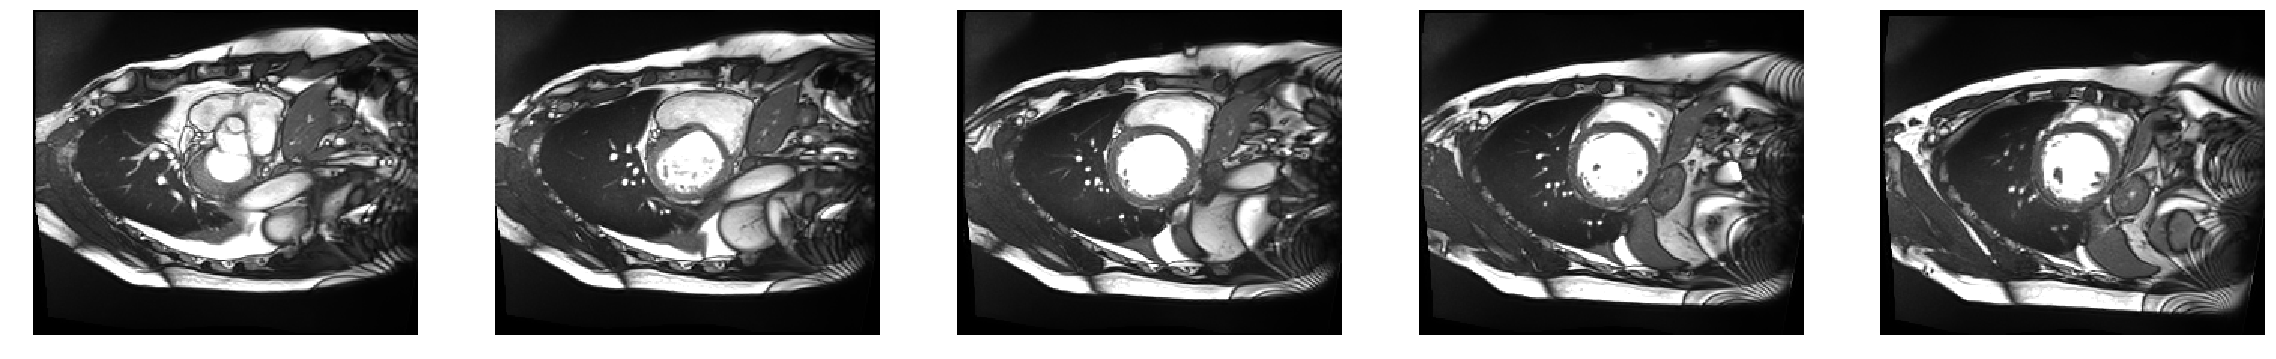

MRImageSegment (10, 1, 216, 256)


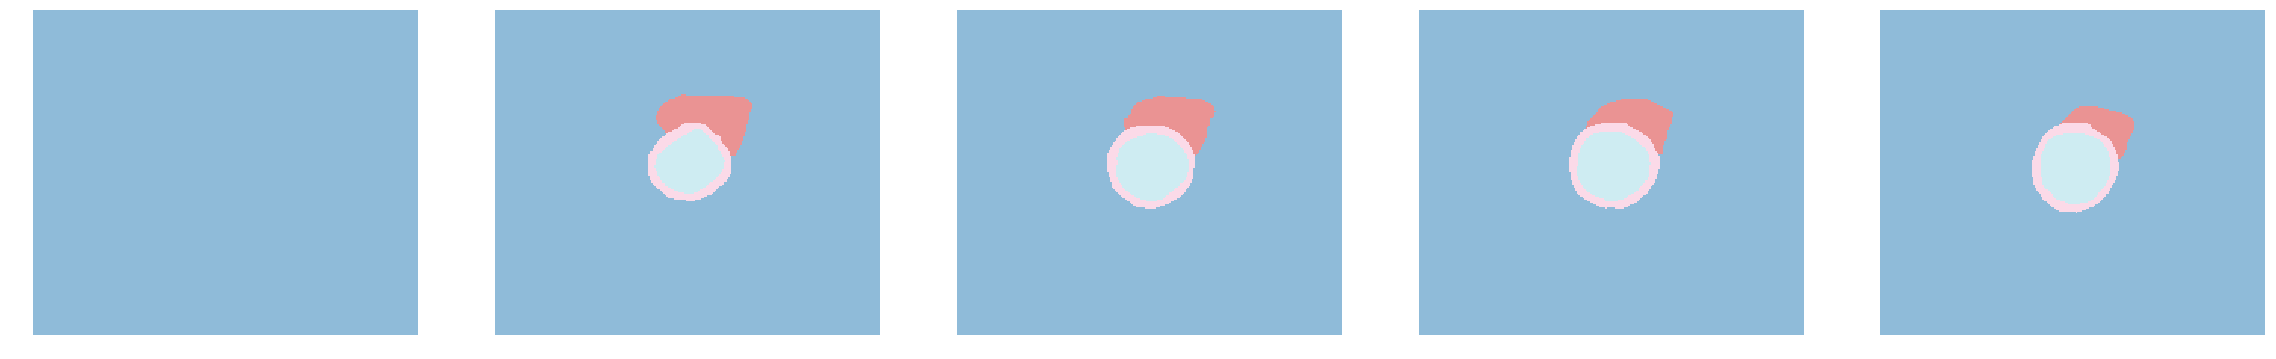

In [ ]:
fn = str(path/'patient001/patient001_frame01.nii.gz')
get_mask = lambda fn: fn[:-7]+'_gt.nii.gz'
mri = open_mri(fn)
mri_mask = open_mri_mask(get_mask(fn))
for m in [mri, mri_mask]:
    print(m)
    m.show(title='MRI Patient 1')
    plt.show()

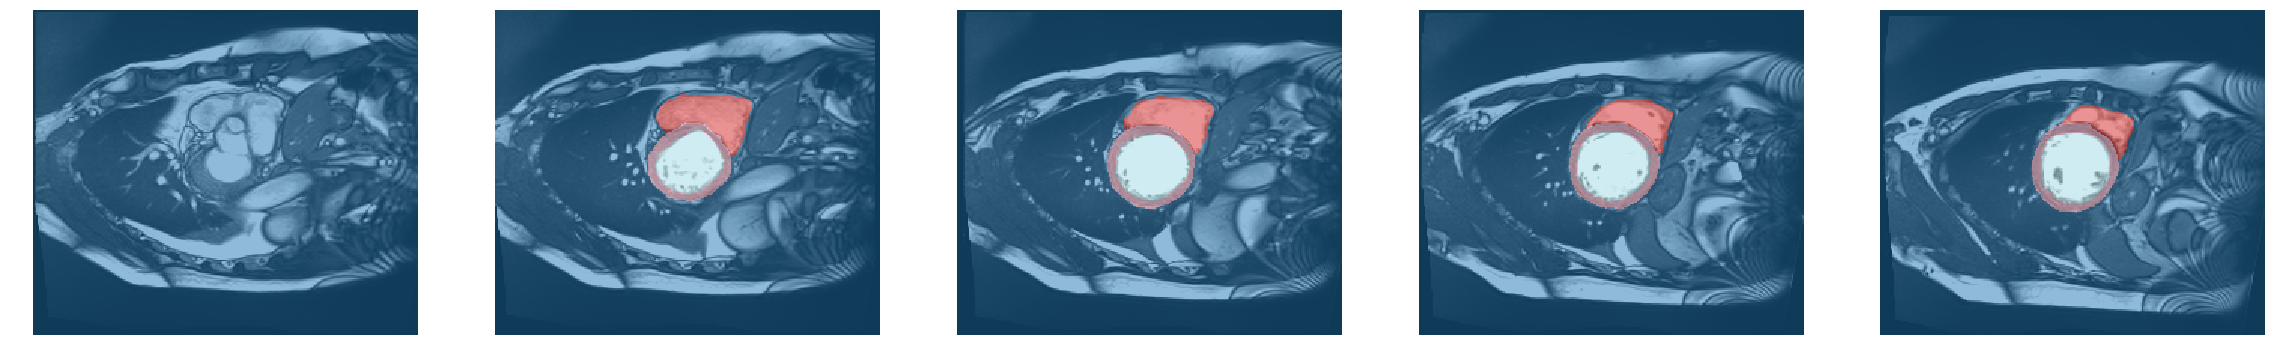

In [ ]:
mri.show(y=mri_mask, )

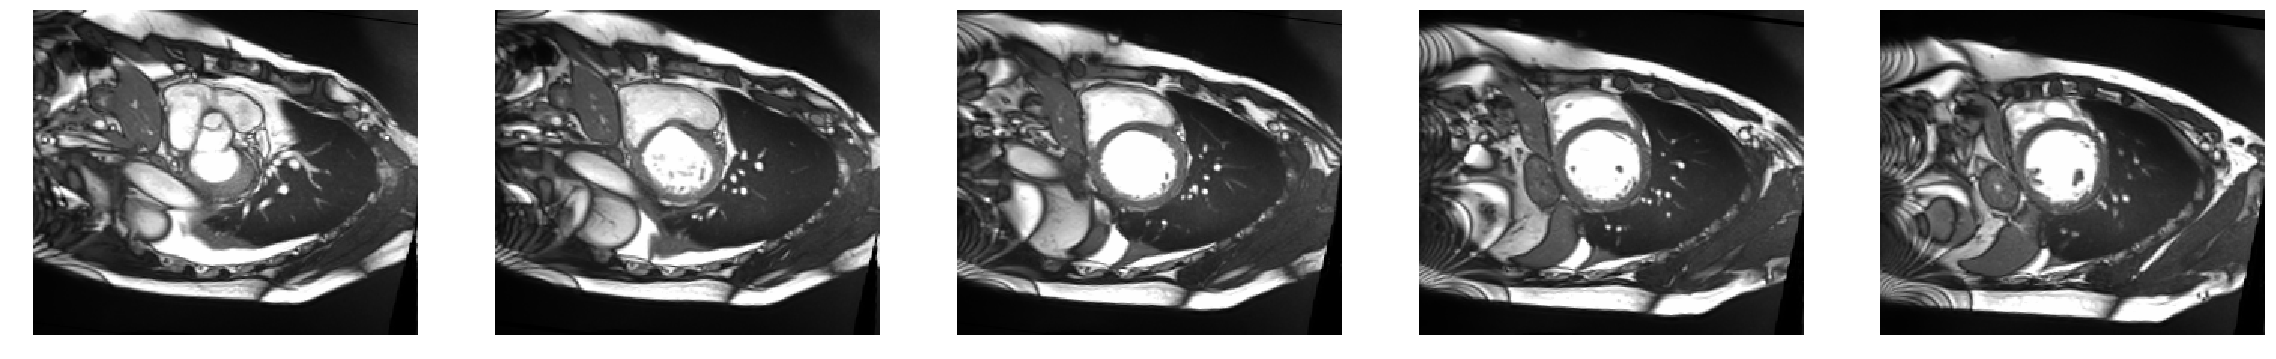

In [ ]:
tfms = get_transforms()
mri.apply_tfms(tfms[0], slicewise=False).show()

"slicewise = True" creates mismatch between slices and their labels!


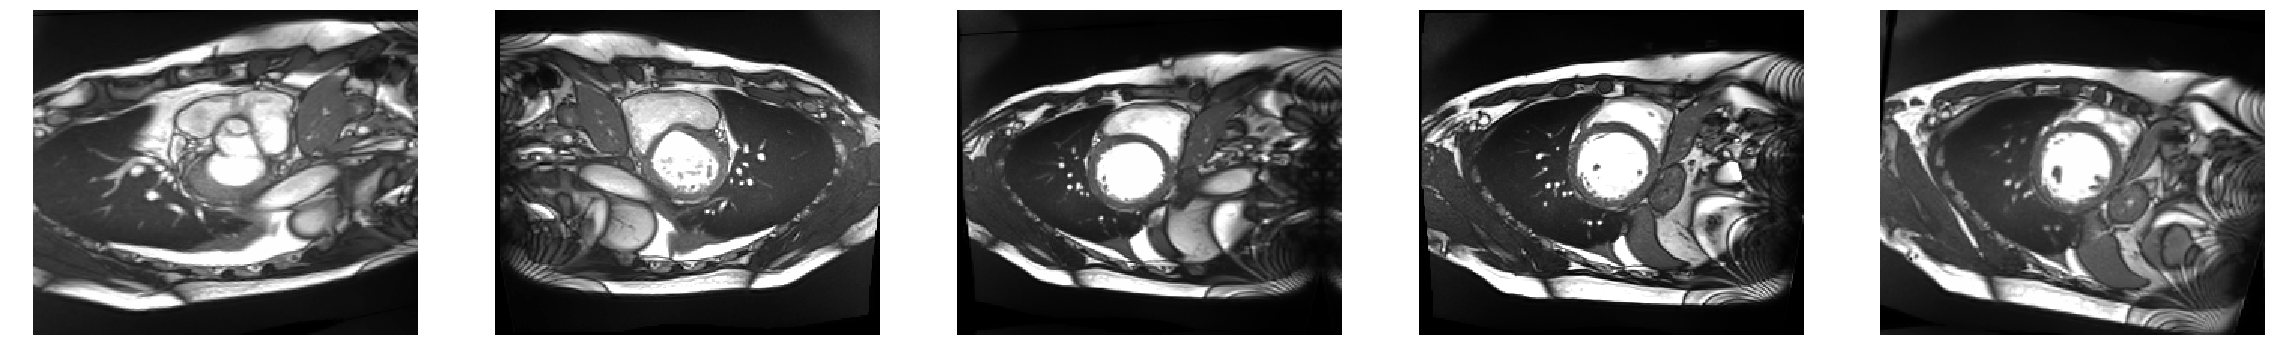

In [ ]:
mri.apply_tfms(tfms[0], slicewise=True).show()

In [ ]:
#export
class MRImageList(ImageList):
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_mri(fn, convert_mode=self.convert_mode, after_open=self.after_open)
    
    def reconstruct(self, t:Tensor): return MRImage(t.float().clamp(min=0,max=1))

    def show_xys(self, xs, ys, imgsize:int=10, figsize:Optional[Tuple[int,int]]=None,
                 slice_idxs=np.arange(5), **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        for x,y in zip(xs, ys): x.show(y=y, slice_idxs=slice_idxs, **kwargs)

    def show_xyzs(self, xs, ys, zs, imgsize:int=10, figsize:Optional[Tuple[int,int]]=None,
                  slice_idxs=np.arange(5), **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            raise Exception('Case not handle yet !')
#             title = 'Ground truth\nPredictions'
#             rows, cols = len(xs), len(slice_idxs)
#             print(cols)
#             axs = subplots(rows, cols, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
#             for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): 
#                 x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
#             for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            for (x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(y=y, slice_idxs=slice_idxs, **kwargs)
                x.show(y=z, slice_idxs=slice_idxs, **kwargs)             
                
class MRImageSegLabelList(MRImageList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=2)
    # Custom label: mask opener
    def open(self, fn): return open_mri(fn, div=False, convert_mode='L', cls=MRImageSegment)
    
    def analyze_pred(self, pred, thresh:float=0.5):
        return pred.argmax(dim=1)[None]
        # .permute(1,0,2,3)
    
    def reconstruct(self, t:Tensor):
#         print('LabelList tensor:',t.shape)
        return MRImageSegment(t)

class MRISegItemList(MRImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = MRImageSegLabelList,False


In [ ]:
v_idxs = [0, 2, 9, 4]
codes = np.array(['background', "RV", 'Myocardium', 'LV'])
get_mask = lambda fn: fn[:-7]+'_gt.nii.gz'
mris = (MRISegItemList.from_csv(path, 'data_sample.csv')
                   .split_by_idx(v_idxs)
                   .label_from_func(get_mask, classes=codes)
                   .transform(get_transforms(), size=(10,100, 122), tfm_y=True)
                   .databunch(bs=3)
       )

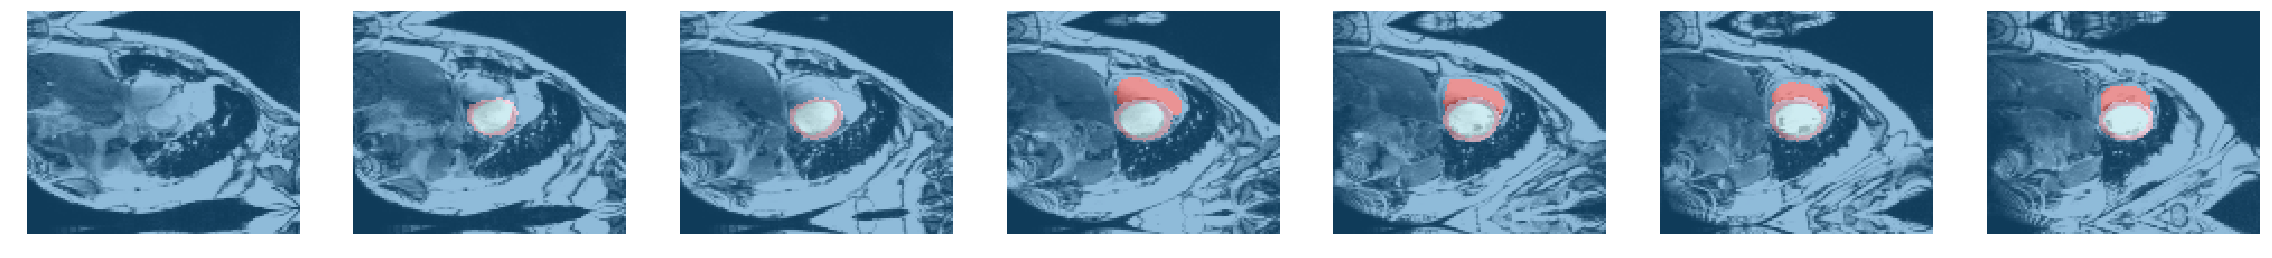

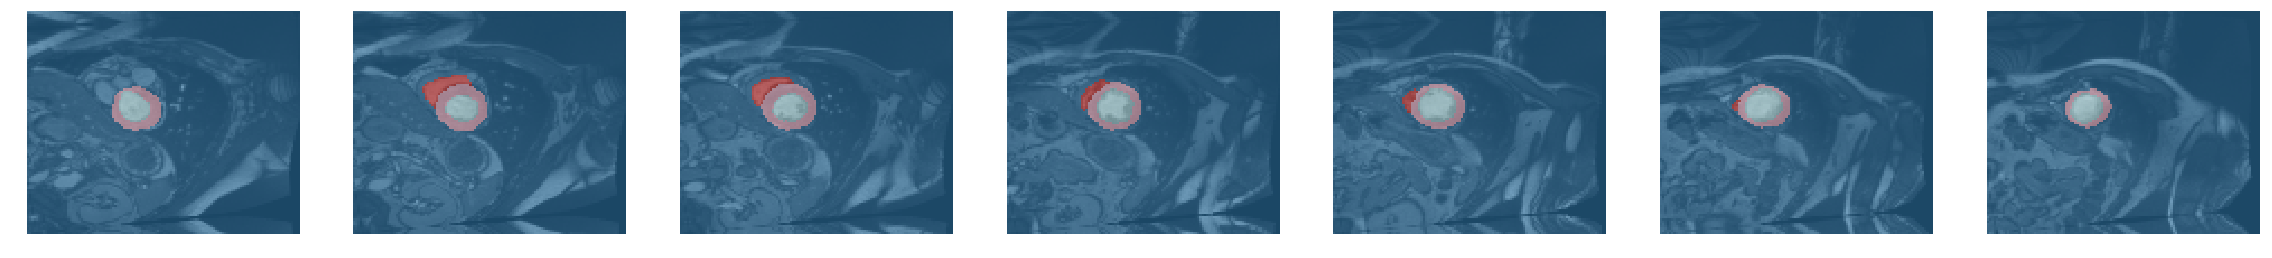

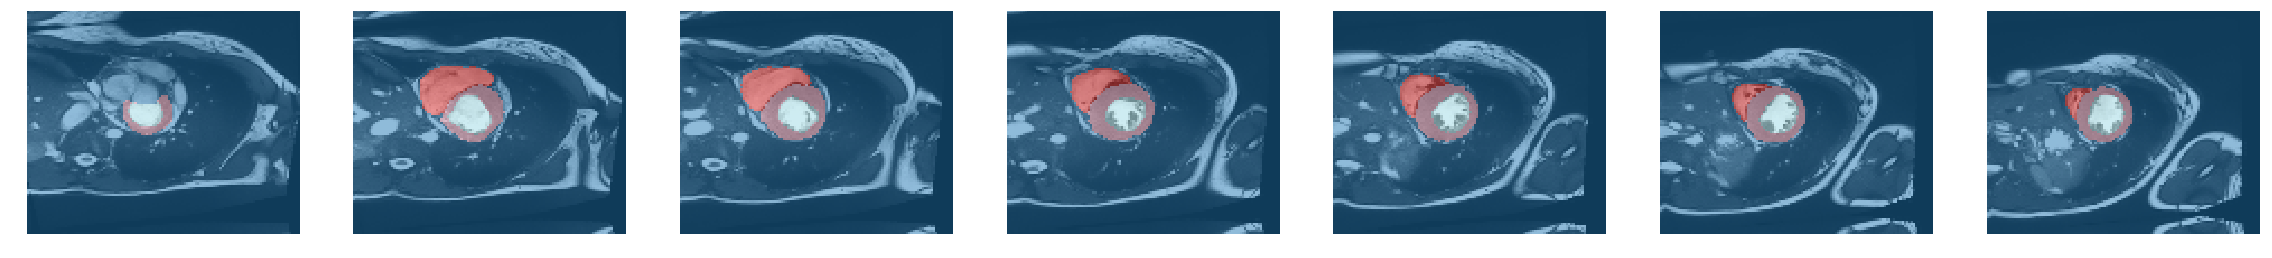

In [ ]:
mris.show_batch(slice_idxs=np.arange(7))